# Import Libraries

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report




# Data Read In

In [179]:
df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/Fraud_Detection_Dataset.csv')

# Check the Data
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No


In [180]:
# Describe to see the stats about the data

df.describe()

,Transaction ID,Customer ID,Transaction Amount,Previous Transaction Amount,Time Since Last Transaction
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,3010.561100,559.865608,461.410984,677.040726
std,2886.89568,1152.371939,399.984400,334.582413,432.386769
min,1.00000,1000.000000,1.000000,0.000000,1.000000
25%,2500.75000,2001.750000,262.969956,181.109688,295.523894
50%,5000.50000,3004.000000,522.370941,404.367010,653.143168
75%,7500.25000,4010.000000,788.415931,676.079655,1048.479972
max,10000.00000,4999.000000,2953.394492,1500.000000,1694.715674


In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               10000 non-null  int64  
 1   Customer ID                  10000 non-null  int64  
 2   Transaction Amount           10000 non-null  float64
 3   Transaction Date and Time    10000 non-null  object 
 4   Merchant Category            10000 non-null  object 
 5   Location                     10000 non-null  object 
 6   Previous Transaction Amount  10000 non-null  float64
 7   Time Since Last Transaction  10000 non-null  float64
 8   Device Type                  10000 non-null  object 
 9   Fraud                        10000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 781.4+ KB


##### We don't see any missing values
##### However date seems to be in wrong format. So we will correct that

In [182]:
df['Transaction Date and Time'] = pd.to_datetime(df['Transaction Date and Time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Transaction ID               10000 non-null  int64         
 1   Customer ID                  10000 non-null  int64         
 2   Transaction Amount           10000 non-null  float64       
 3   Transaction Date and Time    10000 non-null  datetime64[ns]
 4   Merchant Category            10000 non-null  object        
 5   Location                     10000 non-null  object        
 6   Previous Transaction Amount  10000 non-null  float64       
 7   Time Since Last Transaction  10000 non-null  float64       
 8   Device Type                  10000 non-null  object        
 9   Fraud                        10000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 781.4+ KB


In [183]:
# Check the Data
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No


In [184]:
fraud_count = df.groupby(['Fraud']).size()
fraud_count

Fraud
No     8608
Yes    1392
dtype: int64

##### The seems very imbalanced

In [185]:
df.columns

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type', 'Fraud'],
      dtype='object')

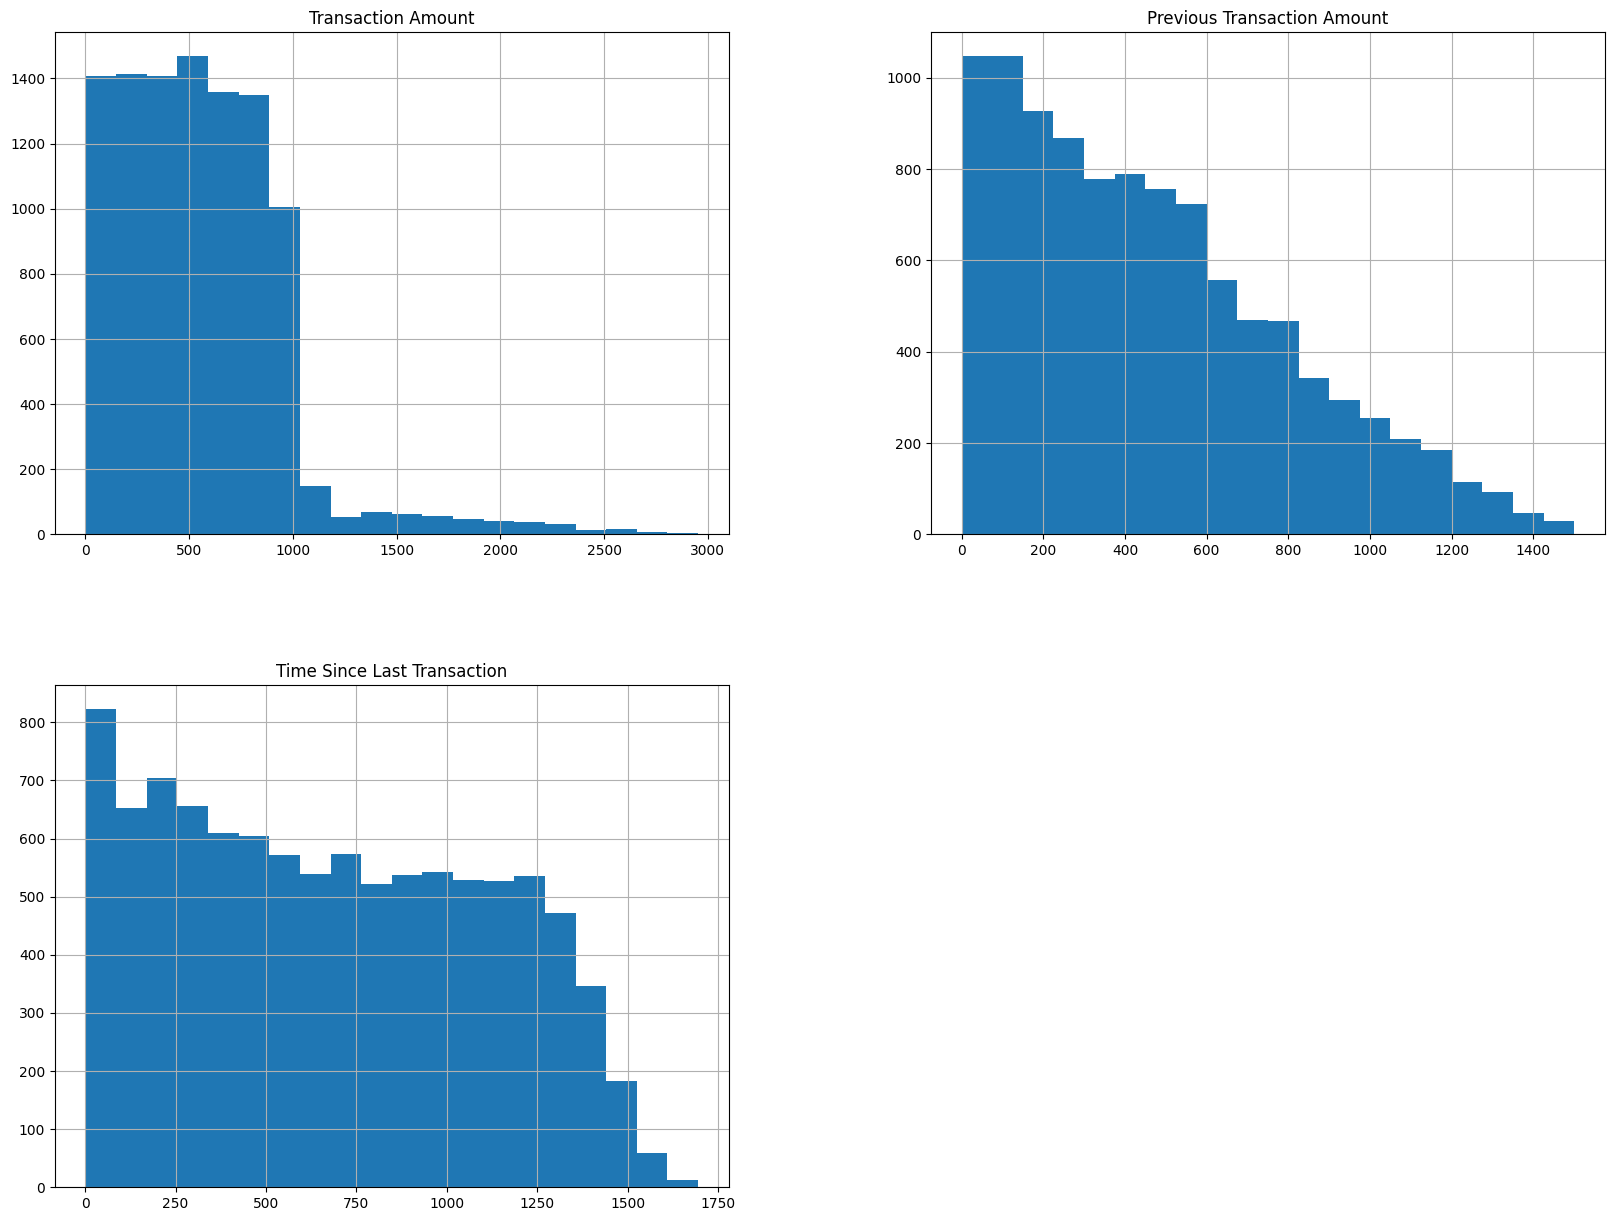

In [186]:
numeric_features = ['Transaction Amount','Previous Transaction Amount', 'Time Since Last Transaction']
df[numeric_features].hist(bins=20, figsize=(20, 15))
plt.show()

/var/folders/kv/6kn50zx13db29c7_5l_npqc40000gn/T/ipykernel_9899/1123074833.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Fraud', y='Transaction Amount', data=df, palette='viridis')


Text(0, 0.5, 'Transacti0n Amount')

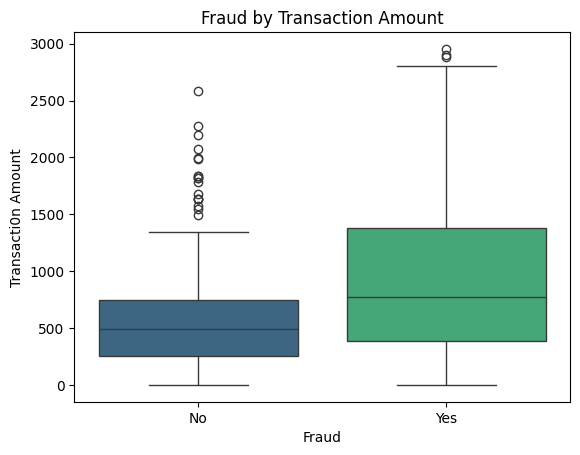

In [187]:
# Transaction Amount Analysis
sns.boxplot(x='Fraud', y='Transaction Amount', data=df, palette='viridis')
plt.title('Fraud by Transaction Amount')
plt.xlabel('Fraud')
plt.ylabel('Transacti0n Amount')

/var/folders/kv/6kn50zx13db29c7_5l_npqc40000gn/T/ipykernel_9899/3155845779.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Fraud', y='Previous Transaction Amount', data=df, palette='viridis')


Text(0, 0.5, 'Previous Transaction Amount')

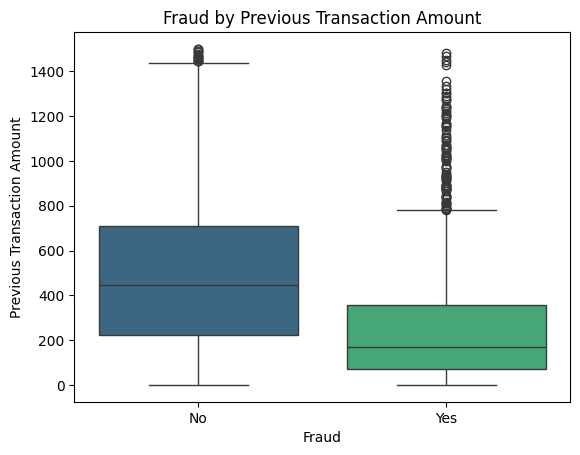

In [188]:
# Previous Transaction Amount Analysis
sns.boxplot(x='Fraud', y='Previous Transaction Amount', data=df, palette='viridis')
plt.title('Fraud by Previous Transaction Amount')
plt.xlabel('Fraud')
plt.ylabel('Previous Transaction Amount')

/var/folders/kv/6kn50zx13db29c7_5l_npqc40000gn/T/ipykernel_9899/3105265692.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Fraud', y='Time Since Last Transaction', data=df, palette='viridis')


Text(0, 0.5, 'Time Since Last Transaction')

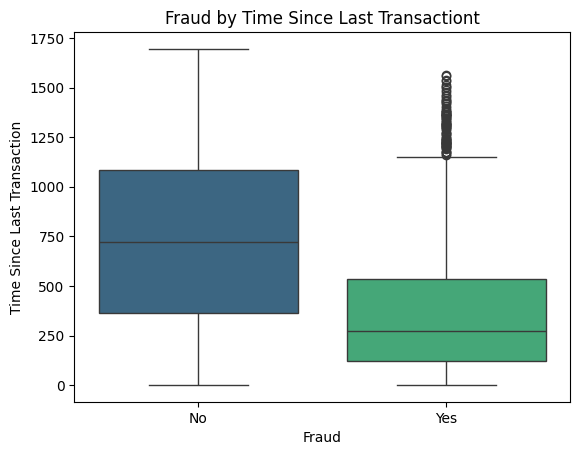

In [189]:
# Time Since Last Transaction 
sns.boxplot(x='Fraud', y='Time Since Last Transaction', data=df, palette='viridis')
plt.title('Fraud by Time Since Last Transactiont')
plt.xlabel('Fraud')
plt.ylabel('Time Since Last Transaction')

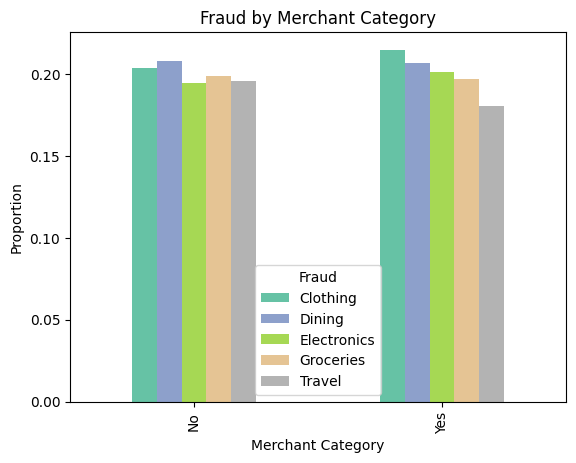

In [190]:
merch_cat = df.groupby('Fraud')['Merchant Category'].value_counts(normalize=True).unstack().fillna(0)
merch_cat.plot(kind='bar', stacked=False, colormap='Set2')
plt.title('Fraud by Merchant Category')
plt.xlabel('Merchant Category')
plt.ylabel('Proportion')
plt.legend(title='Fraud')
plt.show()

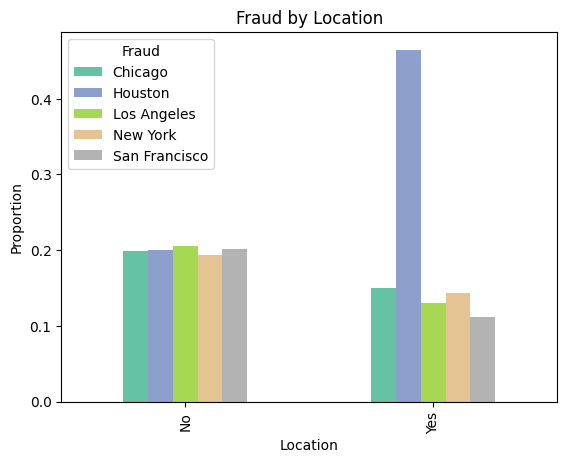

In [191]:


loc = df.groupby('Fraud')['Location'].value_counts(normalize=True).unstack().fillna(0)
loc.plot(kind='bar', stacked=False, colormap='Set2')
plt.title('Fraud by Location')
plt.xlabel('Location')
plt.ylabel('Proportion')
plt.legend(title='Fraud')
plt.show()

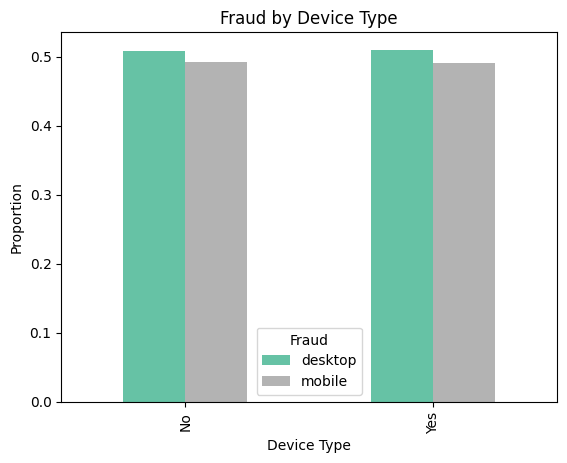

In [192]:
dev_type = df.groupby('Fraud')['Device Type'].value_counts(normalize=True).unstack().fillna(0)
dev_type.plot(kind='bar', stacked=False, colormap='Set2')
plt.title('Fraud by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Proportion')
plt.legend(title='Fraud')
plt.show()

In [193]:
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No


In [194]:
df.columns

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type', 'Fraud'],
      dtype='object')

In [195]:
df['Fraud'] = df['Fraud'].apply(lambda x: 1 if x == 'Yes' else 0)
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,0
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,0
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,0
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,0
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,0


In [196]:
cat_features = ['Merchant Category', 'Location','Device Type']
X = df[['Transaction Amount', 'Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type']]

X_encoded = pd.get_dummies(X, columns=cat_features, dtype=int)


y = df['Fraud']

In [197]:
X_encoded

,Transaction Amount,Previous Transaction Amount,Time Since Last Transaction,Merchant Category_Clothing,Merchant Category_Dining,Merchant Category_Electronics,Merchant Category_Groceries,Merchant Category_Travel,Location_Chicago,Location_Houston,Location_Los Angeles,Location_New York,Location_San Francisco,Device Type_desktop,Device Type_mobile
0,659.297095,579.323704,481.377516,1,0,0,0,0,0,0,1,0,0,1,0
1,474.046452,407.220271,1159.211075,0,1,0,0,0,0,1,0,0,0,1,0
2,498.819570,265.583605,720.677284,0,1,0,0,0,0,0,0,0,1,1,0
3,744.199592,1097.259081,1.000000,0,0,1,0,0,0,0,1,0,0,0,1
4,279.181247,238.389682,1378.958721,0,0,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1475.988992,95.068658,414.231539,1,0,0,0,0,0,0,1,0,0,1,0
9996,764.834233,902.506946,1090.687430,1,0,0,0,0,0,0,1,0,0,0,1
9997,882.096776,531.237353,186.667431,0,0,0,0,1,0,0,0,1,0,0,1
9998,1.000000,0.000000,116.343224,0,1,0,0,0,1,0,0,0,0,1,0


In [198]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 42)

In [199]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_features),
        ('cat',OneHotEncoder(), cat_features)
    ]
)

In [200]:
X_encoded

,Transaction Amount,Previous Transaction Amount,Time Since Last Transaction,Merchant Category_Clothing,Merchant Category_Dining,Merchant Category_Electronics,Merchant Category_Groceries,Merchant Category_Travel,Location_Chicago,Location_Houston,Location_Los Angeles,Location_New York,Location_San Francisco,Device Type_desktop,Device Type_mobile
0,659.297095,579.323704,481.377516,1,0,0,0,0,0,0,1,0,0,1,0
1,474.046452,407.220271,1159.211075,0,1,0,0,0,0,1,0,0,0,1,0
2,498.819570,265.583605,720.677284,0,1,0,0,0,0,0,0,0,1,1,0
3,744.199592,1097.259081,1.000000,0,0,1,0,0,0,0,1,0,0,0,1
4,279.181247,238.389682,1378.958721,0,0,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1475.988992,95.068658,414.231539,1,0,0,0,0,0,0,1,0,0,1,0
9996,764.834233,902.506946,1090.687430,1,0,0,0,0,0,0,1,0,0,0,1
9997,882.096776,531.237353,186.667431,0,0,0,0,1,0,0,0,1,0,0,1
9998,1.000000,0.000000,116.343224,0,1,0,0,0,1,0,0,0,0,1,0


In [201]:
# Lets try 3 models on this data
knn = KNeighborsClassifier()
logreg = LogisticRegression(random_state=42)
nb = GaussianNB()
dt = DecisionTreeClassifier(random_state=42)


In [202]:
# cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1', cv=5)
dt_scores = cross_val_score(dt, X_train, y_train, scoring='f1', cv=5)

/Users/priyachaudhuri/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/priyachaudhuri/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [203]:
print(np.mean(knn_scores))
print(np.mean(logreg_scores))
print(np.mean(nb_scores))
print(np.mean(dt_scores))

0.7428371028371028
0.6571978839242447
0.5810031454233376
0.6022842341966572


In [204]:
# KNN

knn = KNeighborsClassifier()

# fit model
knn.fit(X_train, y_train)

# run predictions
pred = knn.predict(X_test)

# metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

# cross validation
crossVal = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')

# print scores
print("Cross Validation F1 Scores:", crossVal)
print("Mean cross validation F1 Score:", np.mean(crossVal))

Accuracy: 0.943
Precision: 0.9420313997936608
Recall Score: 0.943
F1 Score: 0.9382107686787615
Cross Validation F1 Scores: [0.76829268 0.71604938 0.72727273 0.75       0.7607362  0.74698795
 0.72955975 0.69090909 0.78823529 0.76023392]
Mean cross validation F1 Score: 0.7438276992624919


In [205]:
# Naive Bayes

# fit model
nb.fit(X_train, y_train)

# run predictions
pred = nb.predict(X_test)

# metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

# cross validation
crossVal = cross_val_score(nb, X_train, y_train, cv=10, scoring='f1')

# print scores
print("Cross Validation F1 Scores:", crossVal)
print("Mean cross validation F1 Score:", np.mean(crossVal))

Accuracy: 0.8866666666666667
Precision: 0.8825115198408067
Recall Score: 0.8866666666666667
F1 Score: 0.8843861199882143
Cross Validation F1 Scores: [0.57647059 0.57777778 0.57142857 0.64835165 0.56842105 0.58638743
 0.53714286 0.50847458 0.63492063 0.57954545]
Mean cross validation F1 Score: 0.5788920595859978


In [206]:
# Logreg

# fit model
logreg.fit(X_train, y_train)

# run predictions
pred = logreg.predict(X_test)

# metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

# cross validation
crossVal = cross_val_score(logreg, X_train, y_train, cv=10, scoring='f1')

# print scores
print("Cross Validation F1 Scores:", crossVal)
print("Mean cross validation F1 Score:", np.mean(crossVal))

Accuracy: 0.9286666666666666
Precision: 0.9287915070242657
Recall Score: 0.9286666666666666
F1 Score: 0.9192319072705403


/Users/priyachaudhuri/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/priyachaudhuri/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Cross Validation F1 Scores: [0.65306122 0.62068966 0.61744966 0.70063694 0.67973856 0.65789474
 0.63945578 0.60810811 0.7133758  0.67924528]
Mean cross validation F1 Score: 0.6569655755318753


/Users/priyachaudhuri/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [207]:
# Decision Tree

# fit model
dt.fit(X_train, y_train)

# run predictions
pred = dt.predict(X_test)

# metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

# cross validation
crossVal = cross_val_score(dt, X_train, y_train, cv=10, scoring='f1')

# print scores
print("Cross Validation F1 Scores:", crossVal)
print("Mean cross validation F1 Score:", np.mean(crossVal))

Accuracy: 0.879
Precision: 0.8868642283972052
Recall Score: 0.879
F1 Score: 0.8824610931000728
Cross Validation F1 Scores: [0.60962567 0.56281407 0.55721393 0.59223301 0.60287081 0.61616162
 0.56043956 0.54901961 0.6407767  0.59405941]
Mean cross validation F1 Score: 0.5885214381669115


In [208]:
# check for overfitting

pred_train = dt.predict(X_train)
# make predictions on the training data 

pred_test = dt.predict(X_test)
# make predictions on the testing data 

print(f1_score(pred_train, y_train))

print(f1_score(pred_test, y_test))

# f1 score of training data is very high -- training score is much higher than the testing score -- overfitting 
# training prediction is 100% accurate, and the actual testing is significantly lower -- therefore - overfit the model 

1.0
0.5774155995343423


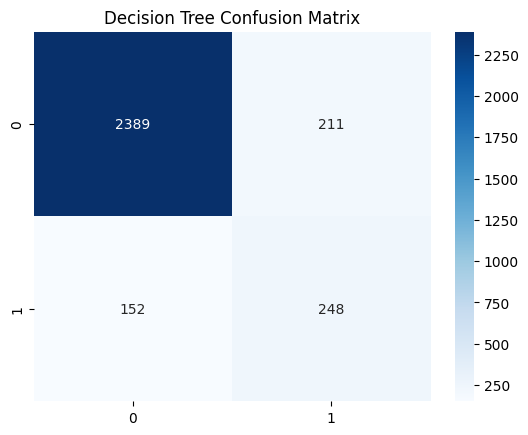

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt
dt_cm = confusion_matrix(y_test, pred)
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

In [210]:
# optimizing for overfitting 
# max_depth 
# min_samples_split
# min_samples_leaf 

params = {'max_depth':[2,4,6,8,10],

          'min_samples_split':[8,10,14,18,24],

          'min_samples_leaf':[4,8,12,16,20]}

# just try with some numbers here -- pick random numbers is fine

In [211]:
random_search = RandomizedSearchCV(dt, params, cv = 5, verbose = 1, scoring = 'f1')

In [212]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'max_depth': [2, 4, 6, 8, 10],
                                        'min_samples_leaf': [4, 8, 12, 16, 20],
                                        'min_samples_split': [8, 10, 14, 18,
                                                              24]},
                   scoring='f1', verbose=1)

In [213]:
print(random_search.best_params_)

{'min_samples_split': 14, 'min_samples_leaf': 8, 'max_depth': 8}


In [214]:
from sklearn.tree import plot_tree


0.7585791691751956
0.7384155455904334


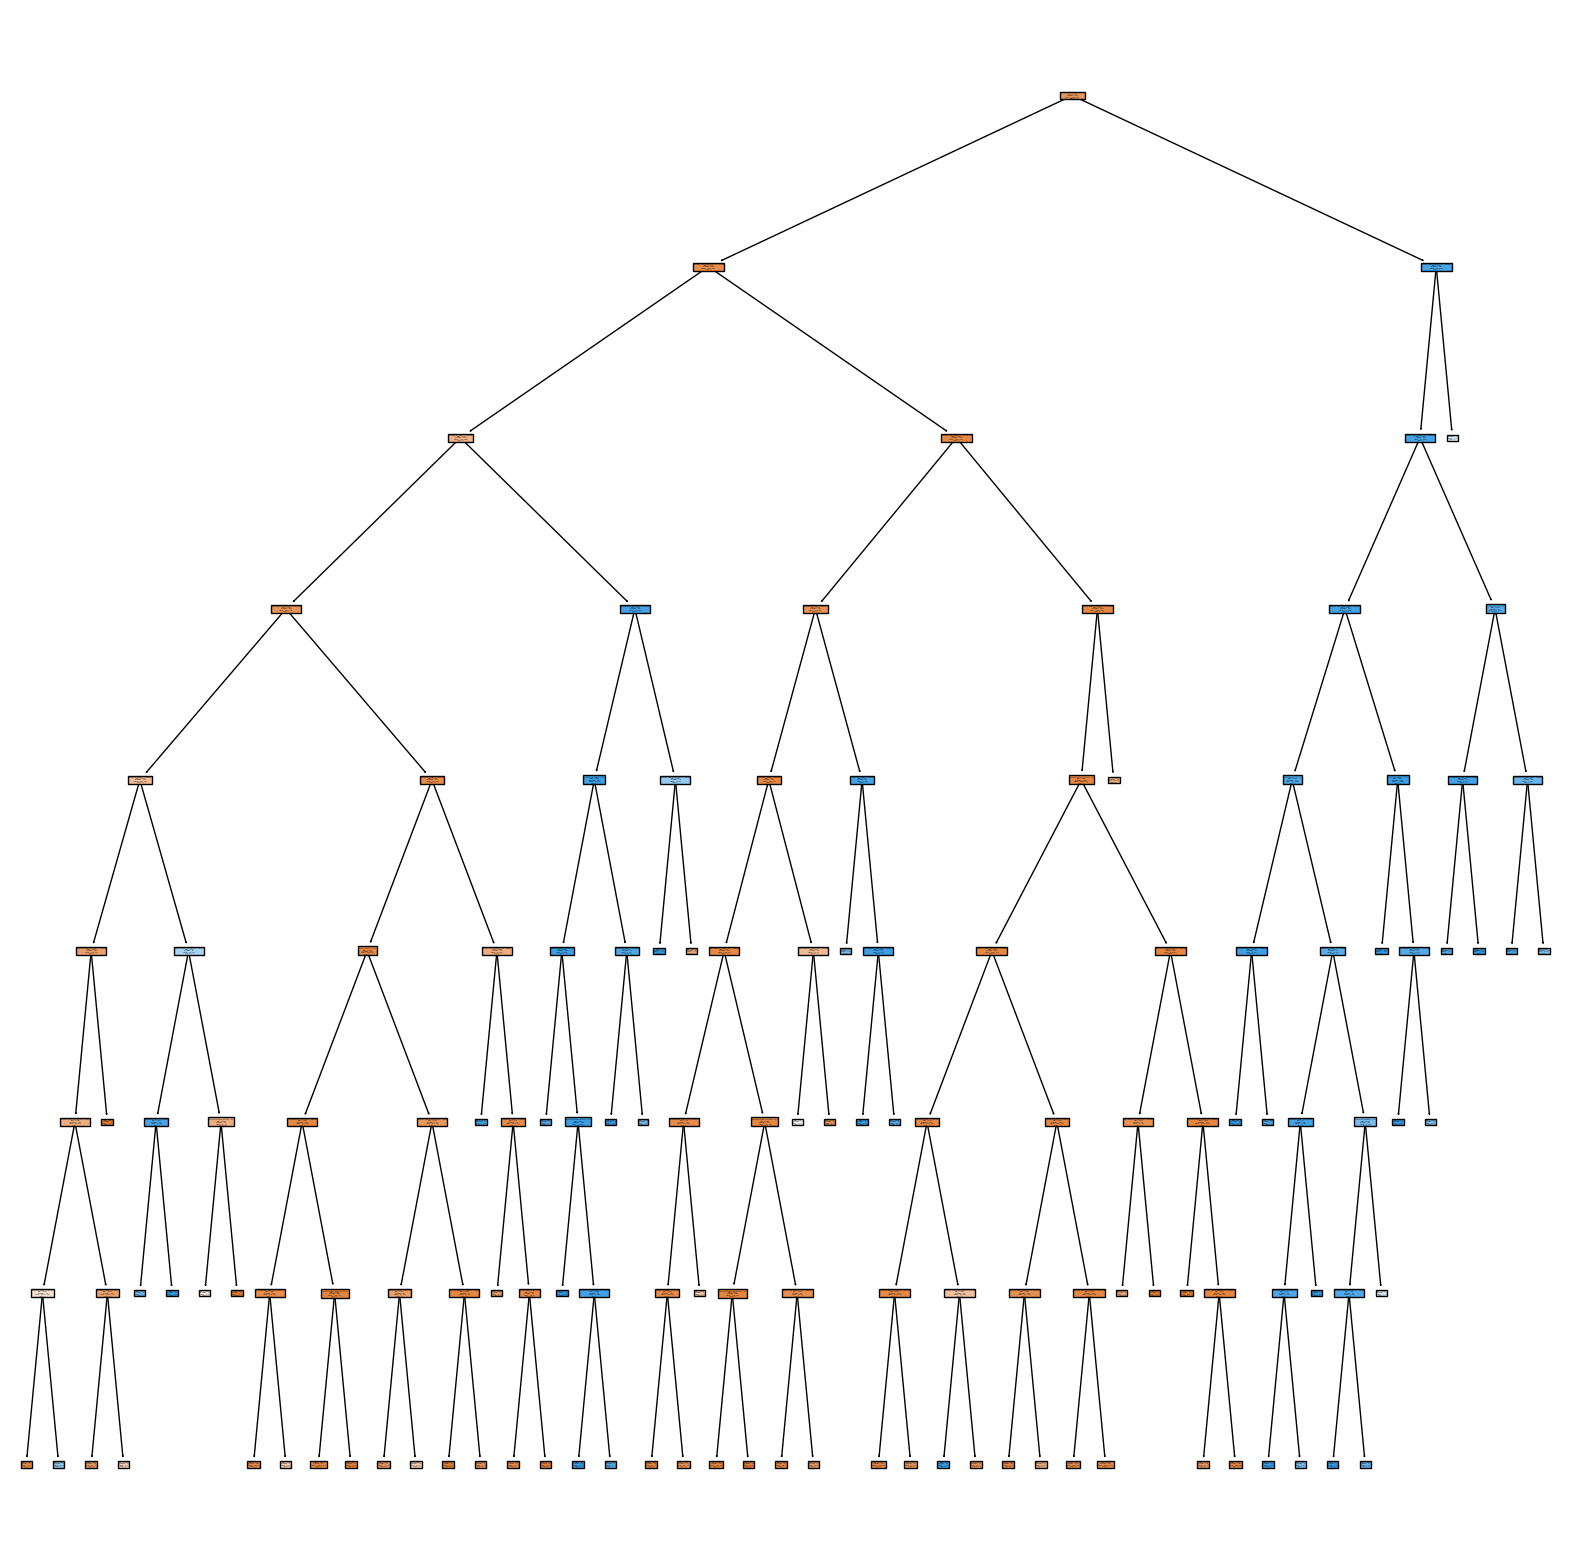

In [215]:
dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=8, min_samples_split=14,random_state=42)   # this is for grid_search 

dt = dt.fit(X_train, y_train)

plt.figure(figsize=(20,20))

plot_tree(dt, filled=True, class_names=['0','1'], feature_names=X_encoded.columns);

pred_train1 = dt.predict(X_train)

pred_test1 = dt.predict(X_test)

print(f1_score(pred_train1, y_train))

print(f1_score(pred_test1, y_test))

# the f1 scores for train and test data here - much more balanced 

In [217]:
print(precision_score(pred_test1, y_test))
print(recall_score(pred_test1, y_test))

0.6175
0.9182156133828996


In [225]:
X_encoded.columns

Index(['Transaction Amount', 'Previous Transaction Amount',
       'Time Since Last Transaction', 'Merchant Category_Clothing',
       'Merchant Category_Dining', 'Merchant Category_Electronics',
       'Merchant Category_Groceries', 'Merchant Category_Travel',
       'Location_Chicago', 'Location_Houston', 'Location_Los Angeles',
       'Location_New York', 'Location_San Francisco', 'Device Type_desktop',
       'Device Type_mobile'],
      dtype='object')

In [226]:
dt_feature_importance = dt.feature_importances_
#onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
all_feature_names = ['Transaction Amount', 'Previous Transaction Amount',
       'Time Since Last Transaction', 'Merchant Category_Clothing',
       'Merchant Category_Dining', 'Merchant Category_Electronics',
       'Merchant Category_Groceries', 'Merchant Category_Travel',
       'Location_Chicago', 'Location_Houston', 'Location_Los Angeles',
       'Location_New York', 'Location_San Francisco', 'Device Type_desktop',
       'Device Type_mobile']
all_feature_names

['Transaction Amount',
 'Previous Transaction Amount',
 'Time Since Last Transaction',
 'Merchant Category_Clothing',
 'Merchant Category_Dining',
 'Merchant Category_Electronics',
 'Merchant Category_Groceries',
 'Merchant Category_Travel',
 'Location_Chicago',
 'Location_Houston',
 'Location_Los Angeles',
 'Location_New York',
 'Location_San Francisco',
 'Device Type_desktop',
 'Device Type_mobile']

In [227]:
dt_feature_importance

array([8.02906288e-01, 1.60863764e-01, 2.56586858e-02, 6.26406158e-04,
       2.41181018e-03, 2.15073023e-04, 2.24768180e-04, 7.25687280e-04,
       0.00000000e+00, 3.31850092e-03, 8.52563820e-04, 0.00000000e+00,
       0.00000000e+00, 2.06290976e-03, 1.33542823e-04])

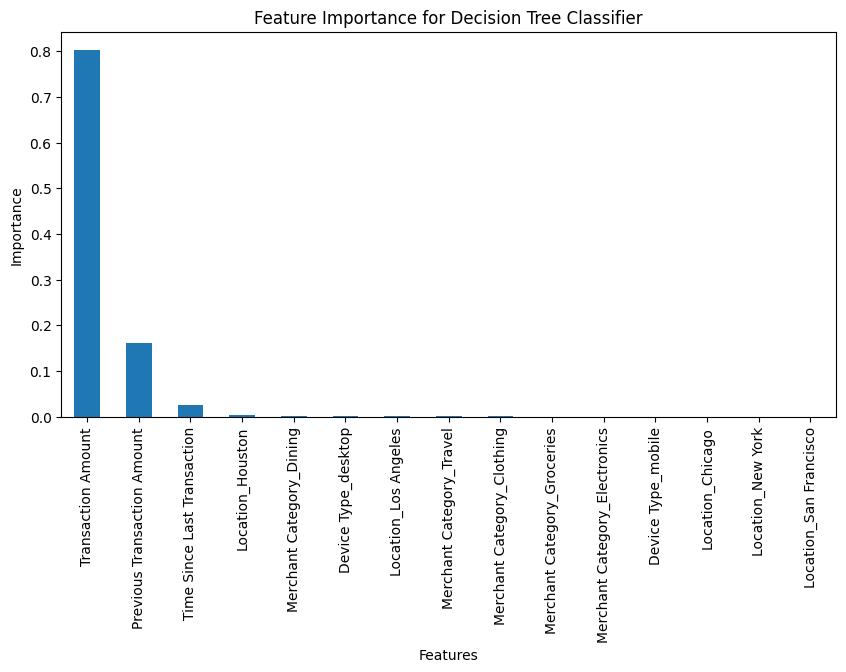

In [228]:
# Plotting feature importance
feature_importance_series = pd.Series(dt_feature_importance, index=all_feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
feature_importance_series.plot(kind='bar')
plt.title('Feature Importance for Decision Tree Classifier')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

Business Problem:

Your company wants to develop a model to detect fraudulent credit card transactions. The goal is to minimize the number of fraudulent transactions that go undetected while also reducing the number of legitimate transactions flagged as fraud. You have been provided with a dataset containing various transaction attributes such as transaction amount, date and time, merchant category, location, previous transaction amount, time since last transaction, and device type used for the transaction. Your task is to analyze the data, build a classification model to predict fraudulent transactions, and evaluate its performance.



# Conclusions

### Data Insights

* The columns were found to contain no null entries.
* The Transaction Date and Time had object type associated which was changed. 
* There were a few outliers found.
* The number of transaction amount, previous transaction amount show a right-skewed distribution, indicating a large number of smaller transaction.
* Houston seems to have a really large number of frauds.
* Clothing Merchant Type seems to have a higher properption of frauds.
* Device Type showed a more general trend.
* The data is imbalanced - so the models might be biased. 

### Hypothesis / Prediction

* Time Since Last spend and Transactions amount are the obvious signs of Fraud. We saw a relation with location as well - Houston had higher frauds detected. 
* Higher transaction amounts and shorter time intervals between transactions are more likely to be associated with fraudulent transactions.
* Based on the above analysis, it is predicted that the following features have an impact on whether or not a transaction is a fraud - location, merchant type, device type, Transaction Amount being greater than Previous Transaction Amount and the time since last transactions
* Based on the feature importance graph we do see the expected results.

### Modelling 

* We created dummy variables for the all the categorical columns - location, merchant type, device type
* Based on the initial cross validation - KNN and Logistic Regression gave better results. 
* However, Logistic Regression and also Naive Bayes cannot be tuned to be optimized - we do not consider them.
* We also have to consider that the dataset as we saw earlier was imbalanced.
* Even though KNN gave better scores, since KNN is sensitive to imbalances, we will consider the next best option which is Decision Tree as the best fit - it deals with imbalances better, does not require to be sclaed and also can be optimized further.
* The initial analysis also showed us that the Decision Tree model is overfitting which is an disadvantage of decision trees

### Model Tuning

* We will optimize for f1 using randomized search. From our business case we see that the goal is to minimize the number of fraudulent transactions that go undetected while also reducing the number of legitimate transactions flagged as fraud.
* Recall (Sensitivity):
capturing all actual fraudulent transactions is critical to minimize the number of fraudulent transactions that go undetected - High recall -  we identify as many fraudulent transactions as possible, even if it means including some false positives.
* Precision:
Reducing the number of legitimate transactions flagged as fraud is equally important to avoid inconveniencing customers and allocating resources efficiently. High precision -  most flagged transactions are indeed fraudulent.
* The F1 score provides a single metric that considers both precision and recall, which is useful when you need a balance between the two.
* Post parameter tuning we see that the best params are: max_depth=8, min_samples_leaf=8, min_samples_split=14 and we also see an improved f1 score from the earlier cross validation f1 score. 
  

### Future Model Use Case

* We can see that the model is predicting True Negatives better. Most due to the imbalance induced bias.
* The model is performing well in predicting transactions that are not fraudulent, indicating that it can accurately identify legitimate transactions 
* A potential use case would be that if the model does predict that a transaction is not fraudulent. This is critical for managing resources efficiently and ensuring that customer support efforts are not wasted on transactions that are not fraudulent. 
* Acquisition and retention costs can be reduced by reducing unnecessary investigations.
* The model can be continuously trained and updated with new data to improve and adapt to new fraud patterns and by effectively reducing fraudulent transactions, the company can enhance customer trust and satisfaction, leading to better customer retention and brand reputation.